# REDES NEURONALES PRACTICA 3 - 2024
# Estadistica de trenes de spikes

Existen dos archivos: `stimulus.dat` y `spikes.dat`. Corresponden a datos experimentales medidos con electrodos intracelulares por Ariel Rokem en un receptor acústico de un saltamontes.

El archivo stimulate.dat contiene la envolvente de la onda sonora que se presentó al animal mientras se medía la actividad de la neurona. Este estímulo se repitió para cada una de las realizaciones. El archivo contiene dos columnas. La primera indica los tiempos (en milisegundos) y la segunda, la intensidad de la envolvente (en decibeles).

El archivo spikes.dat contiene la respuesta de la neurona. Cada una de las 128 líneas de este archivo representa una realización diferente. Cada realización dura un segundo. Este intervalo de tiempo se divide en 10.000 ventanas (cada una de 0,1 milisegundos de duración). En cada línea del archivo hay una secuencia de ceros o unos, indicando el número de spikes detectados en la ventana correspondiente.

## 1. Obtener un histograma que se aproxime a la distribución de intervalos $P(\text{ISI})$ de la neurona, considerando todas las realizaciones. Calcular el coeficiente de variabilidad CV.

Primero comenzamos cargando el contenido de los archivos proporcionados para comprender y verificar la estructura de los datos. El contenido se halla en `spikes.dat` y `stimulus.dat`


In [1]:
import numpy as np

# File paths
spikes_file_path = './spikes.dat'
stimulus_file_path = './stimulus.dat'

# Load the spikes data (binary: 0 or 1)
spikes_data = np.loadtxt(spikes_file_path)

# Load the stimulus data (time and intensity in dB)
stimulus_data = np.loadtxt(stimulus_file_path)

# Check the dimensions of both files to understand their structure
spikes_data.shape, stimulus_data.shape

((128, 10000), (10001, 2))

De esta manera obervamos que el archivo `spikes.dat` contiene $128$ filas y $10,000$ columnas, donde cada fila representa una realización diferente y va a ser un `tren de spikes` y cada columna corresponde a una venta de tiempo de $0,1ms$. En cambio el archivo `stimulus.dat` contiene $10.001$ filas y 2 columnas, donde la primera columna representa el tiempo (en milisegundos) y la segunda columna, la intensidad de la envolvente sonora (en decibeles).

Tambien observamos la señal estimulo:

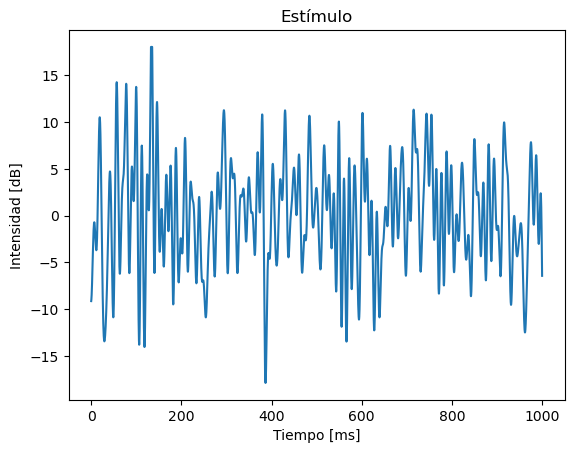

In [4]:
import matplotlib.pyplot as plt
plt.title('Estímulo')
plt.plot(stimulus_data[:,0],stimulus_data[:,1])
plt.xlabel('Tiempo [ms]');
plt.ylabel('Intensidad [dB]');

Ahora, se procede a calculara los intervalos entre picos (**ISI**: Interpikes Interval) a partir de los datos de los `spikes` para crear el histograma para $P(\text{ISI})$ y luego calcular el coeficiente de variabilidad (**CV**).

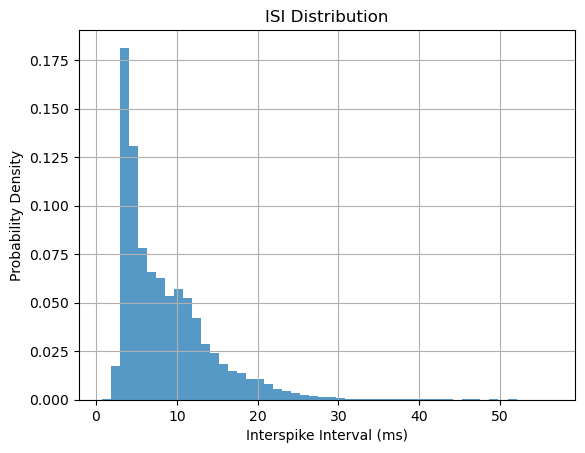

CV = 0.6572287857646663


In [7]:
# Calculate the interspike intervals (ISI) for all realizations

# Function to calculate ISIs for a single realization
def calculate_isi(spike_train):
    # Find the indices where spikes occur (spike_train == 1)
    spike_times = np.where(spike_train == 1)[0]
    # Calculate the differences between consecutive spike times (ISI)
    isi = np.diff(spike_times)
    return isi

# Apply the ISI calculation to all realizations and concatenate all ISIs
all_isis = np.concatenate([calculate_isi(spike_train) for spike_train in spikes_data])

# Convert ISIs from indices to milliseconds (each index represents 0.1 ms)
all_isis_ms = all_isis * 0.1

# Calculate the coefficient of variability (CV)
# CV = standard deviation of ISIs / mean of ISIs
mean_isi = np.mean(all_isis_ms)
std_isi = np.std(all_isis_ms)
cv = std_isi / mean_isi

# Plot histogram of ISI distribution and return CV
import matplotlib.pyplot as plt

plt.hist(all_isis_ms, bins=50, density=True, alpha=0.75)
plt.title('ISI Distribution')
plt.xlabel('Interspike Interval (ms)')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

print(f"CV = {cv}")


Teniendo en cuenta todas las realizaciones, el histograma anterior representa la distribución del intervalo entre picos (`ISI`) $P(ISI)$ para la neurona. El coeficiente de variabilidad (CV) calculado es aproximadamente 0,657, lo que indica la variabilidad en los intervalos entre picos en relación con la media.

## 2 Obtener un histograma que aproxime la probabilidad $P(N)$ de obtener N spikes en una dada realización. Calcular el factor de Fano F. En base a este resultado y al del punto anterior: ¿el proceso de generación de spikes es un proceso tipo renewal?

Para calcular la distribución de probabilidad $P(N)$ de obtener $N$ picos en una realización dada, es necesario contar el número de picos en cada realización. Después, podemos calcular el factor de Fano $F$, definido como:
$$
𝐹 = \frac{ \text{Varianza de } N}{\text{Promedio de } N}
$$
 
donde $N$ representa el número de picos en cada realización.

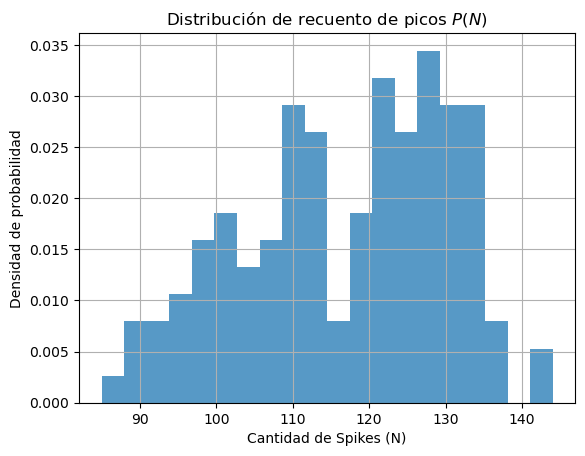

Factor de Fano: 1.5656668349803031


In [10]:
# Calculate the number of spikes (N) in each realization
num_spikes_per_realization = np.sum(spikes_data, axis=1)

# Calculate the Fano factor
mean_spikes = np.mean(num_spikes_per_realization)
var_spikes = np.var(num_spikes_per_realization)
fano_factor = var_spikes / mean_spikes

# Plot histogram for the distribution of spike counts
plt.hist(num_spikes_per_realization, bins=20, density=True, alpha=0.75)
plt.title('Distribución de recuento de picos $P(N)$')
plt.xlabel('Cantidad de Spikes (N)')
plt.ylabel('Densidad de probabilidad')
plt.grid(True)
plt.show()

print(f"Factor de Fano: {fano_factor}")


El histograma anterior muestra la distribución de probabilidad $P(N)$, que representa la probabilidad de observar $N$ picos en una realización dada. El factor Fano calculado $F$ es aproximadamente $1,57$.

Un factor Fano mayor que 1 sugiere que el proceso de `generación de spikes` exhibe más variabilidad que un proceso de Poisson (donde
$F=1$). Además, teniendos en cuenta el coeficiente de variabilidad (`CV`) del análisis anterior, esto indicaría que el proceso de generación no es puramente `renewal` o de renovación. Los intervalos de spikes serían independientes y se distribuirían de manera idéntica en un proceso de renovación. La variabilidad observada sugiere una dinámica más compleja.

## 3 Estimar la tasa de disparo dependiente del tiempo r(t), promediando todas la realizaciones y usando un tamaño de bin adecuado.

### Estimation of Time-Dependent Firing Rate \( r(t) \)

To estimate the time-dependent firing rate \( r(t) \), we average the spike counts over all realizations in time bins. The firing rate in each bin is calculated as:

$$
r(t) = \frac{1}{N} \sum_{i=1}^{N} \frac{S_i(t)}{\Delta t}
$$

where:
- $ N $ is the total number of realizations (128 in this case),
- $ S_i(t) $ represents the number of spikes in the $i$-th realization during the time interval $ \Delta t $,
- $ \Delta t $ is the size of the time bin (in milliseconds).

#### Steps:
1. Choose an appropriate bin size (e.g., 100 ms) for averaging the spike counts over time.
2. For each time bin, sum the spikes across all realizations.
3. Divide the sum by the total number of realizations and the duration of the bin (converted to seconds) to obtain the firing rate in Hz (spikes per second).
4. Plot the time-dependent firing rate \( r(t) \) as a function of time.

This process gives us an approximation of the neuron's firing activity over time based on the stimulus and response data.





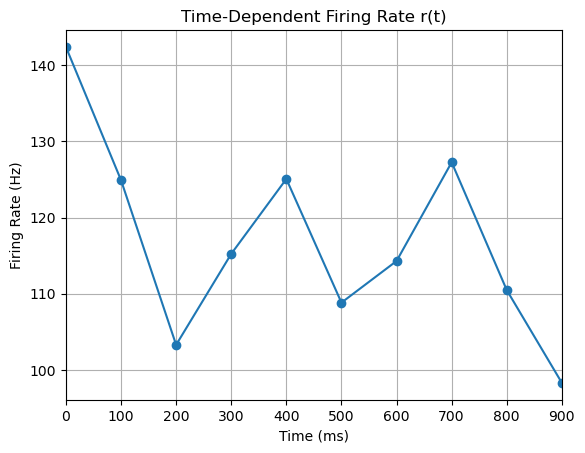

array([142.421875, 124.921875, 103.28125 , 115.234375, 125.078125,
       108.828125, 114.296875, 127.265625, 110.46875 ,  98.28125 ])

In [6]:
# Define the bin size in milliseconds and the corresponding number of time windows
bin_size_ms = 100  # Bin size in ms
bin_size_windows = int(bin_size_ms / 0.1)  # Convert to number of windows (0.1 ms each)

# Initialize the firing rate array
num_bins = spikes_data.shape[1] // bin_size_windows
firing_rate = np.zeros(num_bins)

# Compute the firing rate for each bin
for bin_idx in range(num_bins):
    # Calculate the start and end indices for the current bin
    start_idx = bin_idx * bin_size_windows
    end_idx = start_idx + bin_size_windows
    # Count the spikes across all realizations in the current bin
    firing_rate[bin_idx] = np.sum(spikes_data[:, start_idx:end_idx]) / spikes_data.shape[0] / (bin_size_ms / 1000)  # Convert to Hz

# Time vector for the firing rate
time_vector = np.arange(0, num_bins * bin_size_ms, bin_size_ms)

# Plot the time-dependent firing rate
plt.plot(time_vector, firing_rate, marker='o')
plt.title('Time-Dependent Firing Rate r(t)')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.grid(True)
plt.xlim(0, time_vector[-1])
plt.show()

firing_rate


## 4 Calcular el filtro asociado a esta neurona, que da la mejor prediccion lineal del histograma dependiente del tiempo $r(t)$. Despreciar el tiempo de autocorrelación del estímulo.

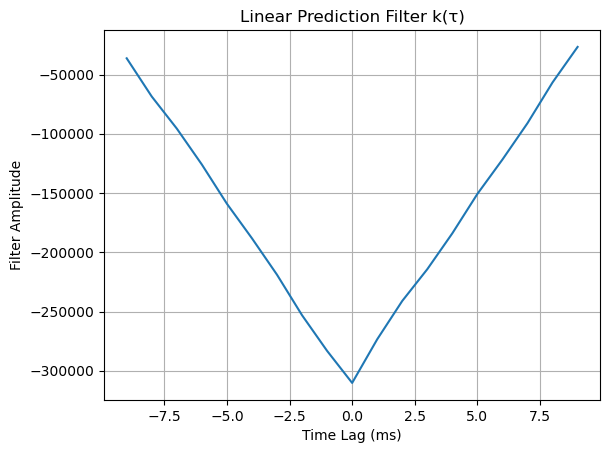

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load the stimulus data (time and intensity in dB)
stimulus_data = np.loadtxt('stimulus.dat')
time_stimulus = stimulus_data[:, 0]
stimulus = stimulus_data[:, 1]

# Assuming you have already computed the time-dependent firing rate r(t)
# Replace 'firing_rate' with your previously computed array
# And 'time_vector' with the corresponding time vector for the firing rate

# Ensure both time arrays match in size by trimming or interpolating if necessary
stimulus = stimulus[:len(time_vector)]  # Ensure stimulus and r(t) are of the same length

# Compute the cross-correlation between the stimulus and the firing rate
cross_corr = np.correlate(firing_rate, stimulus, mode='full')

# Normalize by the stimulus variance (power)
stimulus_variance = np.var(stimulus)
filter_k = cross_corr / stimulus_variance

# Time shift vector for the filter (lags)
lags = np.arange(-len(time_vector) + 1, len(time_vector))

# Plot the filter
plt.plot(lags, filter_k)
plt.title('Linear Prediction Filter k(τ)')
plt.xlabel('Time Lag (ms)')
plt.ylabel('Filter Amplitude')
plt.grid(True)
plt.show()
